In [1]:
import pandas as pd
import numpy as np
import torch

In [2]:
data = pd.read_csv("../data/preprocessed/Event_traces.csv")

In [3]:
# Drop 30% of 'Success' rows to reduce memory consumption
success_idx = (
    data.loc[data["Label"] == "Success"]
        .sample(frac=0.40, random_state=42)
        .index
)
data = data.drop(success_idx).reset_index(drop=True)

In [4]:
# convert string sequence to list sequence
data["Features"] = data["Features"].map(lambda x: x[1:-1].split(","))

# can map timeinterval with the operation ran
data["TimeInterval"] = data["TimeInterval"].map(lambda x: [float(i) for i in x[1:-1].split(",")])

In [5]:
data["Features"]

0         [E5, E22, E5, E5, E11, E11, E9, E9, E11, E9, E...
1         [E5, E5, E22, E5, E11, E9, E11, E9, E11, E9, E...
2         [E5, E22, E5, E5, E11, E9, E11, E9, E11, E9, E...
3         [E5, E5, E22, E5, E11, E9, E11, E9, E11, E9, E...
4         [E5, E5, E22, E5, E11, E9, E11, E9, E11, E9, E...
                                ...                        
351767    [E5, E11, E9, E5, E11, E9, E5, E11, E9, E26, E...
351768    [E5, E5, E5, E22, E11, E9, E11, E9, E11, E9, E...
351769    [E5, E22, E5, E5, E26, E11, E9, E11, E9, E11, ...
351770    [E5, E22, E5, E5, E11, E9, E26, E11, E9, E11, ...
351771    [E5, E5, E5, E22, E11, E9, E11, E9, E11, E9, E...
Name: Features, Length: 351772, dtype: object

In [6]:
# NOTE: One-Hot Encoding (Temporarily commented out to reduce memory consumption)
# Either we use one-hot encoding or text embedding to represent the log features/text

from sklearn.preprocessing import OneHotEncoder

unique_features = data["Features"].map(lambda x: [i[1:] for i in x]).explode().unique().astype(np.int32)
unique_features.sort()

encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
encoded_features = encoder.fit(unique_features.reshape(-1, 1))

data["Features_Encoded"] = data["Features"].map(lambda x: encoder.transform([[int(i[1:])] for i in x]))

In [7]:
# clean data to reduce memory usage
data = data[["Features_Encoded", "TimeInterval", "Label"]]

In [8]:
data

,Features_Encoded,TimeInterval,Label
0,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Success
1,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Success
2,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",Fail
3,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 1.0, 48.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Success
4,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 11.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0...",Success
...,...,...,...
351767,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Success
351768,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Success
351769,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Success
351770,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Success


In [9]:
# Maximum length of sequence is chosen as 50 based on the distribution of sequence lengths
# Sequences beyond this length are rare and has drippled effect on buiding even sequences
# (i.e., padding/truncating) for training. Most short or medium sequences from 1 -> 40 in
# length are padded up to 200s if this maximum length is not chosen.

MAX_LEN = 50 # maximum sequence length
ENCODED_DIMEN = data["Features_Encoded"].iloc[0].shape[1]  # for 'one-hot' encoding

# pad with zeros on the left to create even sequences for training
def left_pad_feature(seq, pad_len=MAX_LEN, encoded_dim=ENCODED_DIMEN):
    seq = np.stack(seq)  # shape: (L, 384)
    L = seq.shape[0]
    if L >= pad_len:
        return seq[-pad_len:]  # truncate if too long
    pad = np.zeros((pad_len - L, encoded_dim), dtype=seq.dtype)
    return np.vstack([pad, seq])

In [10]:
data["Features_Encoded_Padded"] = data["Features_Encoded"].map(left_pad_feature)

In [11]:
data = data[["Features_Encoded_Padded", "TimeInterval", "Label"]]

In [12]:
data["Features_Encoded_Padded"] = data["Features_Encoded_Padded"].map(lambda x: torch.from_numpy(x))

/var/folders/mt/4n2d597j4sl1j43rj4qnsn1w0000gn/T/ipykernel_74417/4010852748.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Features_Encoded_Padded"] = data["Features_Encoded_Padded"].map(lambda x: torch.from_numpy(x))


In [13]:
label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
encoded_labels = label_encoder.fit_transform(data["Label"].values.reshape(-1, 1))

In [14]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

In [15]:
# Prepare features and labels
X = torch.stack(data["Features_Encoded_Padded"].tolist())  # shape: (N, seq_len, 29)
y = torch.from_numpy(encoded_labels)       # shape: (N, num_classes)

In [16]:
X.size(), y.size()

(torch.Size([351772, 50, 29]), torch.Size([351772, 2]))

In [40]:
# Train/test split (80/20)
N = len(X)
train_size = int(0.8 * N)
test_size = N - train_size
dataset = torch.utils.data.TensorDataset(X, y)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [41]:
# LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=384, hidden_dim=128, num_layers=1, num_classes=None):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        _, (hn, _) = self.lstm(x)  # hn: (num_layers, batch, hidden_dim)
        out = self.fc(hn[-1])      # use last layer's hidden state
        return out


In [42]:
num_classes = y.shape[1]
model = LSTMClassifier(input_dim=ENCODED_DIMEN, hidden_dim=16, num_layers=1, num_classes=num_classes)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss() if num_classes > 1 else nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [43]:
# Training loop (1 epoch for demonstration)
for epoch in range(3):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} loss: {avg_loss:.4f}")

Epoch 1 loss: 0.0423
Epoch 2 loss: 0.0106
Epoch 3 loss: 0.0037


In [44]:
from sklearn.metrics import classification_report

all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb)
        
        if num_classes > 1:
            # Multi-class/One-hot: use argmax to get class index (0, 1, etc.)
            preds = torch.argmax(logits, dim=1)
            targets = torch.argmax(yb, dim=1)
        else:
            # Binary (single output neuron): threshold at 0
            preds = (logits > 0).float().view(-1)
            targets = yb.view(-1)
            
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Get readable class names from the label encoder
class_names = [str(c) for c in label_encoder.categories_[0]]

print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=class_names, digits=4))

Classification Report:
              precision    recall  f1-score   support

        Fail     0.9916    0.9971    0.9943      3419
     Success     0.9999    0.9996    0.9997     66936

    accuracy                         0.9994     70355
   macro avg     0.9957    0.9983    0.9970     70355
weighted avg     0.9994    0.9994    0.9994     70355



Classification Report:
              precision    recall  f1-score   support

        Fail     0.9916    0.9971    0.9943      3419
     Success     0.9999    0.9996    0.9997     66936

    accuracy                         0.9994     70355
   macro avg     0.9957    0.9983    0.9970     70355
weighted avg     0.9994    0.9994    0.9994     70355



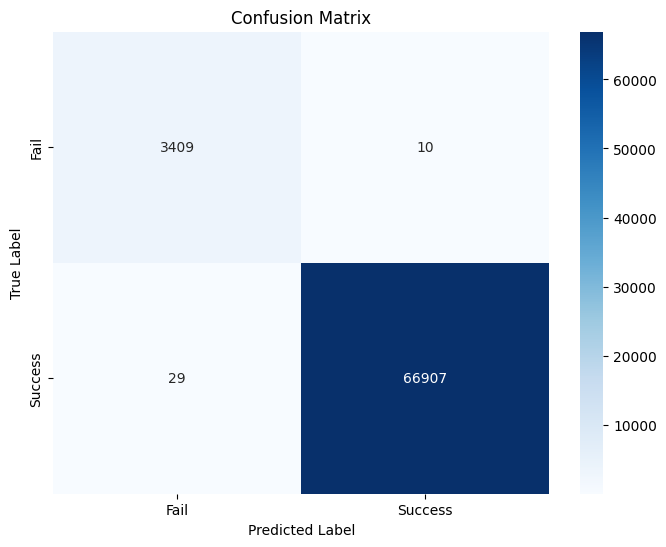

In [45]:
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=class_names, digits=4))

# --- Visual Evaluation: Confusion Matrix ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
